In [1]:
!pip install transformers torch matplotlib seaborn ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.5 MB/s eta 0:00:00


In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import DistilBertTokenizer, DistilBertModel
import ipywidgets as widgets
from IPython.display import display, clear_output
import warnings
warnings.filterwarnings('ignore')

In [7]:
class AttentionExplorer:

    def __init__(self):
        print("Loading DistilBERT model and tokenizer...")
        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        self.model = DistilBertModel.from_pretrained('distilbert-base-uncased',
                                                   output_attentions=True)
        self.model.eval()

        self.num_layers = self.model.config.n_layers
        self.num_heads = self.model.config.n_heads

        print(f"Model loaded successfully!")
        print(f"Layers: {self.num_layers}, Heads per layer: {self.num_heads}")

        self.current_tokens = None
        self.current_attentions = None

    def process_sentence(self, sentence):
        print(f"Processing sentence: '{sentence}'")
        inputs = self.tokenizer(sentence, return_tensors='pt', add_special_tokens=True)
        tokens = self.tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

        with torch.no_grad():
            outputs = self.model(**inputs)
            attentions = outputs.attentions

        attention_arrays = []
        for layer_attention in attentions:
            attention_arrays.append(layer_attention.squeeze(0).numpy())

        self.current_tokens = tokens
        self.current_attentions = attention_arrays

        print(f"Tokens: {tokens}")
        print(f"Sequence length: {len(tokens)}")

        return tokens, attention_arrays

    def plot_attention_heatmap(self, layer_idx, head_idx=None, figsize=(10, 8)):

        if self.current_attentions is None:
            print("Please process a sentence first!")
            return

        layer_attention = self.current_attentions[layer_idx]

        if head_idx is not None:
            attention_matrix = layer_attention[head_idx]
            title = f'Attention Heatmap - Layer {layer_idx + 1}, Head {head_idx + 1}'
        else:
            attention_matrix = np.mean(layer_attention, axis=0)
            title = f'Aggregated Attention Heatmap - Layer {layer_idx + 1} (All Heads)'

        plt.figure(figsize=figsize)

        sns.heatmap(attention_matrix,
                   xticklabels=self.current_tokens,
                   yticklabels=self.current_tokens,
                   cmap='Blues',
                   annot=True if len(self.current_tokens) <= 10 else False,
                   fmt='.3f',
                   cbar_kws={'label': 'Attention Weight'})

        plt.title(title, fontsize=14, fontweight='bold')
        plt.xlabel('Key Tokens', fontsize=12)
        plt.ylabel('Query Tokens', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

    def plot_attention_summary(self, figsize=(15, 10)):

        if self.current_attentions is None:
            print("Please process a sentence first!")
            return

        fig, axes = plt.subplots(2, 3, figsize=figsize)
        axes = axes.flatten()

        for layer_idx in range(self.num_layers):
            layer_attention = self.current_attentions[layer_idx]
            aggregated_attention = np.mean(layer_attention, axis=0)

            sns.heatmap(aggregated_attention,
                       xticklabels=self.current_tokens,
                       yticklabels=self.current_tokens,
                       cmap='Blues',
                       ax=axes[layer_idx],
                       cbar=True,
                       cbar_kws={'shrink': 0.8})

            axes[layer_idx].set_title(f'Layer {layer_idx + 1}', fontweight='bold')
            axes[layer_idx].set_xlabel('Key Tokens')
            axes[layer_idx].set_ylabel('Query Tokens')
            axes[layer_idx].tick_params(axis='x', rotation=45)

        plt.suptitle('Attention Patterns Across All Layers (Aggregated)',
                    fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()

    def get_attention_stats(self):

        if self.current_attentions is None:
            print("Please process a sentence first!")
            return

        print("\n" + "="*50)
        print("ATTENTION STATISTICS")
        print("="*50)

        for layer_idx in range(self.num_layers):
            layer_attention = self.current_attentions[layer_idx]

            layer_mean = np.mean(layer_attention)
            layer_std = np.std(layer_attention)
            layer_max = np.max(layer_attention)

            print(f"\nLayer {layer_idx + 1}:")
            print(f"  Mean attention: {layer_mean:.4f}")
            print(f"  Std deviation: {layer_std:.4f}")
            print(f"  Max attention: {layer_max:.4f}")

            aggregated = np.mean(layer_attention, axis=0)
            max_idx = np.unravel_index(np.argmax(aggregated), aggregated.shape)
            max_attention = aggregated[max_idx]

            query_token = self.current_tokens[max_idx[0]]
            key_token = self.current_tokens[max_idx[1]]

            print(f"  Highest attention: '{query_token}' -> '{key_token}' ({max_attention:.4f})")

In [8]:
def create_interactive_explorer():

    explorer = AttentionExplorer()

    sentence_input = widgets.Text(
        value="The cat sat on the mat.",
        description="Sentence:",
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='500px')
    )

    layer_dropdown = widgets.Dropdown(
        options=[(f"Layer {i+1}", i) for i in range(explorer.num_layers)],
        value=0,
        description="Layer:",
    )

    head_dropdown = widgets.Dropdown(
        options=[("Aggregated (All Heads)", None)] + [(f"Head {i+1}", i) for i in range(explorer.num_heads)],
        value=None,
        description="Head:",
    )

    process_button = widgets.Button(
        description="Process Sentence",
        button_style='info',
        icon='play'
    )

    plot_button = widgets.Button(
        description="Plot Attention",
        button_style='success',
        icon='chart-line'
    )

    summary_button = widgets.Button(
        description="Show All Layers",
        button_style='warning',
        icon='th'
    )

    stats_button = widgets.Button(
        description="Show Statistics",
        button_style='primary',
        icon='info-circle'
    )

    output_area = widgets.Output()

    def on_process_clicked(b):
        with output_area:
            clear_output(wait=True)
            try:
                explorer.process_sentence(sentence_input.value)
                print("Sentence processed successfully!")
                print("Now you can plot attention patterns using the buttons below.")
            except Exception as e:
                print(f"Error processing sentence: {e}")

    def on_plot_clicked(b):
        with output_area:
            clear_output(wait=True)
            try:
                explorer.plot_attention_heatmap(layer_dropdown.value, head_dropdown.value)
            except Exception as e:
                print(f"Error plotting attention: {e}")

    def on_summary_clicked(b):
        with output_area:
            clear_output(wait=True)
            try:
                explorer.plot_attention_summary()
            except Exception as e:
                print(f"Error plotting summary: {e}")

    def on_stats_clicked(b):
        with output_area:
            clear_output(wait=True)
            try:
                explorer.get_attention_stats()
            except Exception as e:
                print(f"Error getting statistics: {e}")

    process_button.on_click(on_process_clicked)
    plot_button.on_click(on_plot_clicked)
    summary_button.on_click(on_summary_clicked)
    stats_button.on_click(on_stats_clicked)

    input_box = widgets.VBox([
        widgets.HTML("<h3> Interactive Multi-Head Attention Explorer</h3>"),
        sentence_input,
        process_button,
        widgets.HTML("<br><h4>Visualization Options:</h4>"),
        widgets.HBox([layer_dropdown, head_dropdown]),
        widgets.HBox([plot_button, summary_button, stats_button]),
        widgets.HTML("<br>")
    ])

    full_interface = widgets.VBox([input_box, output_area])

    return full_interface, explorer

In [9]:
def main():

    print("Creating Interactive Multi-Head Attention Explorer...")
    interface, explorer = create_interactive_explorer()

    display(interface)

    print("\n" + "="*60)
    print("DIRECT API USAGE EXAMPLE:")
    print("="*60)
    print("# You can also use the explorer directly:")
    print("# explorer = AttentionExplorer()")
    print("# tokens, attentions = explorer.process_sentence('Hello world!')")
    print("# explorer.plot_attention_heatmap(layer_idx=0, head_idx=0)")
    print("# explorer.plot_attention_summary()")
    print("# explorer.get_attention_stats()")

    return explorer

In [10]:
if __name__ == "__main__":
    explorer = main()

Creating Interactive Multi-Head Attention Explorer...
Loading DistilBERT model and tokenizer...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Model loaded successfully!
Layers: 6, Heads per layer: 12



DIRECT API USAGE EXAMPLE:
# You can also use the explorer directly:
# explorer = AttentionExplorer()
# tokens, attentions = explorer.process_sentence('Hello world!')
# explorer.plot_attention_heatmap(layer_idx=0, head_idx=0)
# explorer.plot_attention_summary()
# explorer.get_attention_stats()


In [11]:
def compare_sentences_attention(explorer, sentence1, sentence2, layer_idx=0):

    print(f"Comparing attention patterns between sentences at Layer {layer_idx + 1}")

    print(f"\nProcessing: '{sentence1}'")
    tokens1, _ = explorer.process_sentence(sentence1)
    attention1 = np.mean(explorer.current_attentions[layer_idx], axis=0)

    print(f"Processing: '{sentence2}'")
    tokens2, _ = explorer.process_sentence(sentence2)
    attention2 = np.mean(explorer.current_attentions[layer_idx], axis=0)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    sns.heatmap(attention1, xticklabels=tokens1, yticklabels=tokens1,
                cmap='Blues', ax=ax1, cbar_kws={'shrink': 0.8})
    ax1.set_title(f"Sentence 1: '{sentence1[:30]}...' (Layer {layer_idx + 1})")
    ax1.set_xlabel('Key Tokens')
    ax1.set_ylabel('Query Tokens')

    sns.heatmap(attention2, xticklabels=tokens2, yticklabels=tokens2,
                cmap='Reds', ax=ax2, cbar_kws={'shrink': 0.8})
    ax2.set_title(f"Sentence 2: '{sentence2[:30]}...' (Layer {layer_idx + 1})")
    ax2.set_xlabel('Key Tokens')
    ax2.set_ylabel('Query Tokens')

    plt.tight_layout()
    plt.show()

Enter first sentence: The cat sat on the mat.
Enter second sentence: The cat is sleeping on the mat.
Comparing attention patterns between sentences at Layer 1

Processing: 'The cat sat on the mat.'
Processing sentence: 'The cat sat on the mat.'
Tokens: ['[CLS]', 'the', 'cat', 'sat', 'on', 'the', 'mat', '.', '[SEP]']
Sequence length: 9
Processing: 'The cat is sleeping on the mat.'
Processing sentence: 'The cat is sleeping on the mat.'
Tokens: ['[CLS]', 'the', 'cat', 'is', 'sleeping', 'on', 'the', 'mat', '.', '[SEP]']
Sequence length: 10


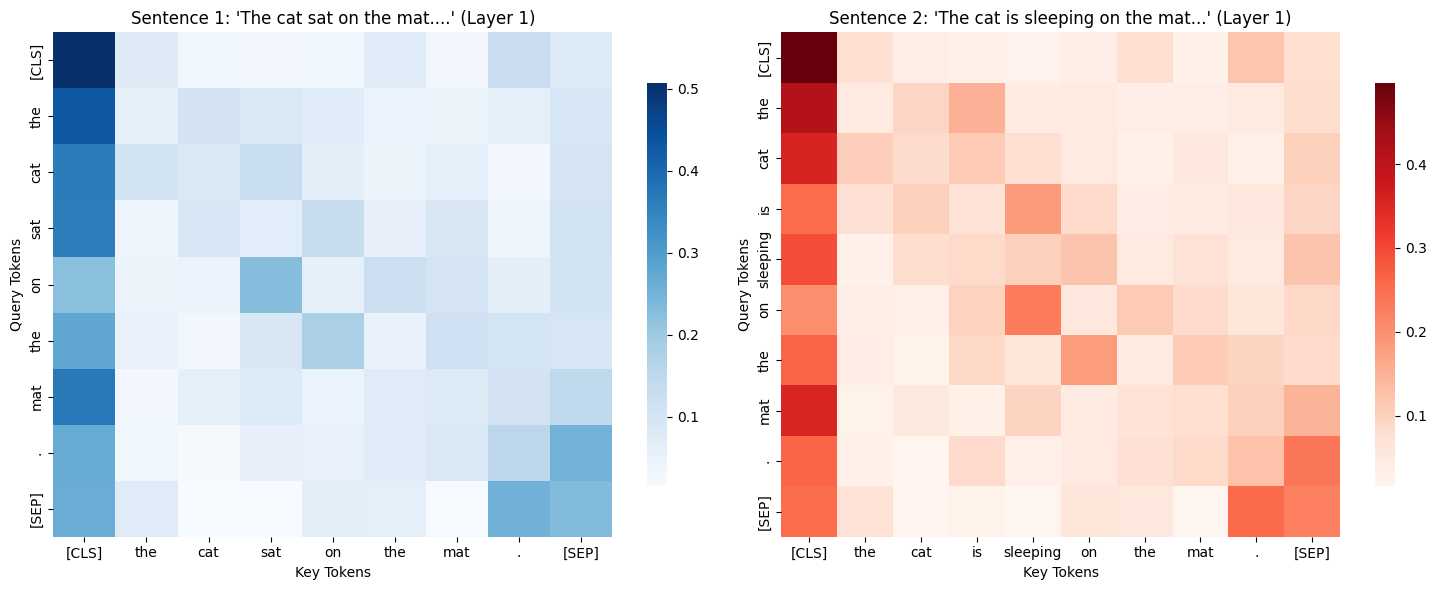

In [12]:
s1, s2 = input("Enter first sentence: "), input("Enter second sentence: ")
compare_sentences_attention(explorer, s1, s2, layer_idx=0)

In [13]:
def analyze_head_diversity(explorer, layer_idx=0):

    if explorer.current_attentions is None:
        print("Please process a sentence first!")
        return

    layer_attention = explorer.current_attentions[layer_idx]
    num_heads = layer_attention.shape[0]

    correlations = np.zeros((num_heads, num_heads))

    for i in range(num_heads):
        for j in range(num_heads):
            att_i = layer_attention[i].flatten()
            att_j = layer_attention[j].flatten()
            correlations[i, j] = np.corrcoef(att_i, att_j)[0, 1]

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlations, annot=True, cmap='coolwarm', center=0,
                xticklabels=[f'Head {i+1}' for i in range(num_heads)],
                yticklabels=[f'Head {i+1}' for i in range(num_heads)])
    plt.title(f'Head-to-Head Attention Correlation (Layer {layer_idx + 1})')
    plt.tight_layout()
    plt.show()

    off_diagonal = correlations[np.triu_indices_from(correlations, k=1)]
    print(f"\nHead Diversity Statistics (Layer {layer_idx + 1}):")
    print(f"Mean correlation: {np.mean(off_diagonal):.3f}")
    print(f"Std correlation: {np.std(off_diagonal):.3f}")
    print(f"Min correlation: {np.min(off_diagonal):.3f}")
    print(f"Max correlation: {np.max(off_diagonal):.3f}")

Enter a sentence: The cat is outside the room.
Processing sentence: 'The cat is outside the room.'
Tokens: ['[CLS]', 'the', 'cat', 'is', 'outside', 'the', 'room', '.', '[SEP]']
Sequence length: 9


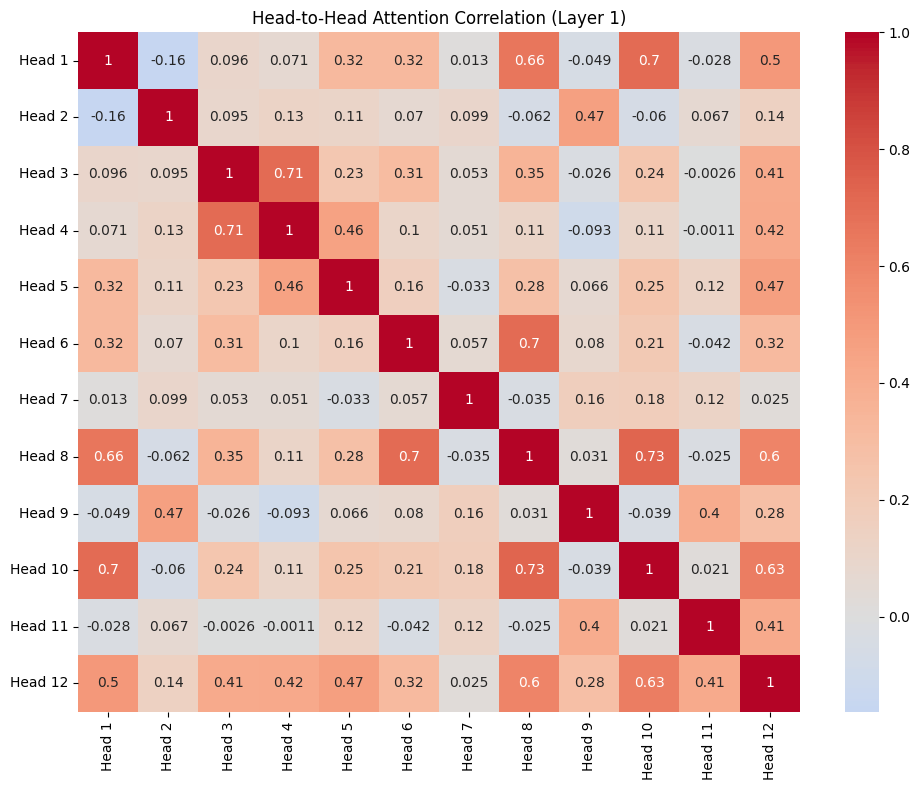


Head Diversity Statistics (Layer 1):
Mean correlation: 0.198
Std correlation: 0.227
Min correlation: -0.163
Max correlation: 0.728


In [14]:
sentence = input("Enter a sentence: ")
explorer.process_sentence(sentence); analyze_head_diversity(explorer, layer_idx=0)